In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import matplotlib as mpl

In [2]:
plt.figure();
import mplhep
mplhep.style.use("CMS")
IRRADIATION_START_TIME_10=np.datetime64('2022-09-26 14:45')
IRRADIATION_START_TIME_9=np.datetime64('2022-09-30 08:20')

<Figure size 432x288 with 0 Axes>

In [3]:
def getPhase_eTx(fName):
    try:
        x=np.loadtxt(fName,delimiter=',',dtype=int) 
    except: 
        x=np.ones(63*13,dtype=int).reshape(63,13)*300
    return x
def getPhase_eRx(fName):
    try:
        x=np.loadtxt(fName,delimiter=',',dtype=int) 
    except: 
        x=np.ones(15*12,dtype=int).reshape(15,12)*300
    return x
       
def consecutive(data, stepsize=1):
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

def get_max_width(err_counts):
    max_width_by_ch = []
    second_max_width_by_ch = []
    err_wrapped=np.concatenate([err_counts,err_counts[:4]])
    for ch in range(12):
        x = err_wrapped[:,ch]
        phases = consecutive(np.argwhere(x<=1).flatten())
        sizes = [np.size(a) for a in phases]
        max_width = max(sizes)
        sizes.remove(max_width)
        try:
            second_max_width = max(sizes)
        except:
            second_max_width = 0
        max_width_by_ch.append(max_width)
        second_max_width_by_ch.append(second_max_width)
    return np.array([max_width_by_ch,second_max_width_by_ch])

def get_best_setting(err_counts):
    best_setting_by_ch = []
    y = (5*err_counts[2:-2]+
         3*err_counts[1:-3]+
         3*err_counts[3:-1]+
         1*err_counts[4:] + 
         1*err_counts[:-4])
    y[ err_counts[2:-2]>0 ] += 2555
    best_setting = y.argmin(axis=0)+2
    return best_setting


def getScanDF(_dir, startTime):
    scanDirs=os.listdir(_dir)

    df=pd.DataFrame({'Timestamp':scanDirs})
    df['Date']=df['Timestamp'].apply(lambda x: pd.to_datetime(x,format="%d%b_%H%M%S").replace(year=2022))

    df=df.loc[df.Date>'2022-09-26 14']
    df.set_index('Date',inplace=True)
    df.sort_index(inplace=True)
    
    t0=(df.index.values-startTime).astype(float)
    t0[t0<0]=0
    TID=t0/3.6e12*8.85
    df['TID']=TID
    df=df.loc[df.TID>0]

    for capSel in [11,12,13,14,15,24,25,26,27,28,29,30,31,56,57,58,59,60,61,62,63,120,121,122,123,124,125,126,127]:
        df[f'phaseScan_CapSel{capSel}_eTx']=df['Timestamp'].apply(lambda x: getPhase_eTx(f'{_dir}/{x}/eTx_DelayScan_CapSelect_{capSel}.csv'))
        df[f'phaseScan_CapSel{capSel}_eRx']=df['Timestamp'].apply(lambda x: getPhase_eRx(f'{_dir}/{x}/eRx_PhaseScan_CapSelect_{capSel}.csv'))
    df
    a={}
    for c in df.columns[2:]:
        x=df[c].apply(get_max_width).values
        a[c+"_bestSetting"]=df[c].apply(get_best_setting)
        a[c+"_width"]=[i[0] for i in x]
        a[c+"_width2"]=[i[1] for i in x]
    return pd.concat([df,pd.DataFrame(a,index=df.index)],axis=1)
#     return df.copy()


In [4]:
df_10_120=getScanDF('phaseScans/board_10/voltage_1_20',startTime=IRRADIATION_START_TIME_10)
df_10_132=getScanDF('phaseScans/board_10/voltage_1_32',startTime=IRRADIATION_START_TIME_10)
df_10_108=getScanDF('phaseScans/board_10/voltage_1_08',startTime=IRRADIATION_START_TIME_10)

In [5]:
df_9_120=getScanDF('phaseScans/board_9/voltage_1_20',startTime=IRRADIATION_START_TIME_9)
df_9_132=getScanDF('phaseScans/board_9/voltage_1_32',startTime=IRRADIATION_START_TIME_9)
df_9_108=getScanDF('phaseScans/board_9/voltage_1_08',startTime=IRRADIATION_START_TIME_9)

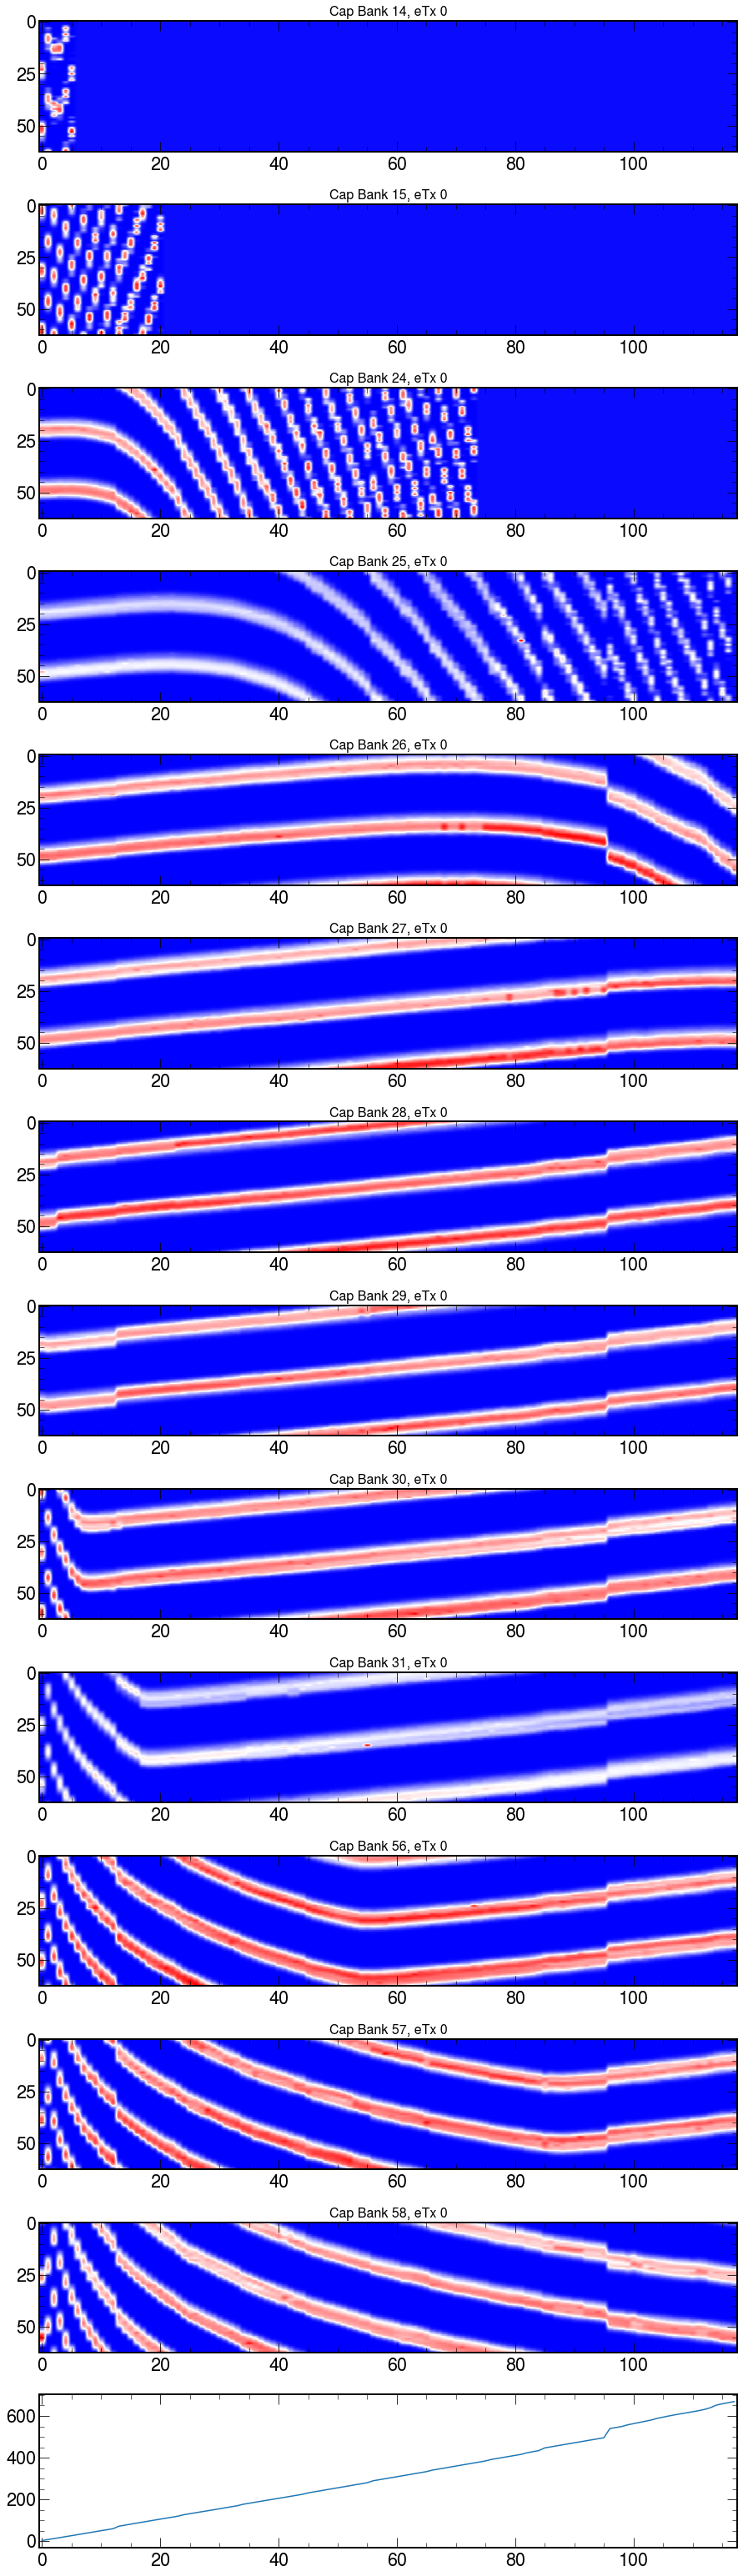

In [6]:
capBanks=[14,15,24,25,26,27,28,29,30,31,56,57,58]
d=df_9_108

fig, ax = plt.subplots(len(capBanks)+1,1,figsize=(15,len(capBanks)*4+4))
iETX=0
for i,n in enumerate(capBanks):
    x=np.array(list((d[f'phaseScan_CapSel{n}_eTx']).values))
    ax[i].imshow(x[:,:,iETX].T,cmap=mpl.colormaps['bwr'])
    ax[i].set_aspect(.35)
    ax[i].set_title(f'Cap Bank {n}, eTx {iETX}',fontsize=16)
#ax.set_xticklabels(df.index.values)

ax[-1].plot(np.arange(len(d)),d.TID)
# ax[1].set_aspect(.5)
ax[-1].set_xlim(-0.5,x.shape[0]-0.5);

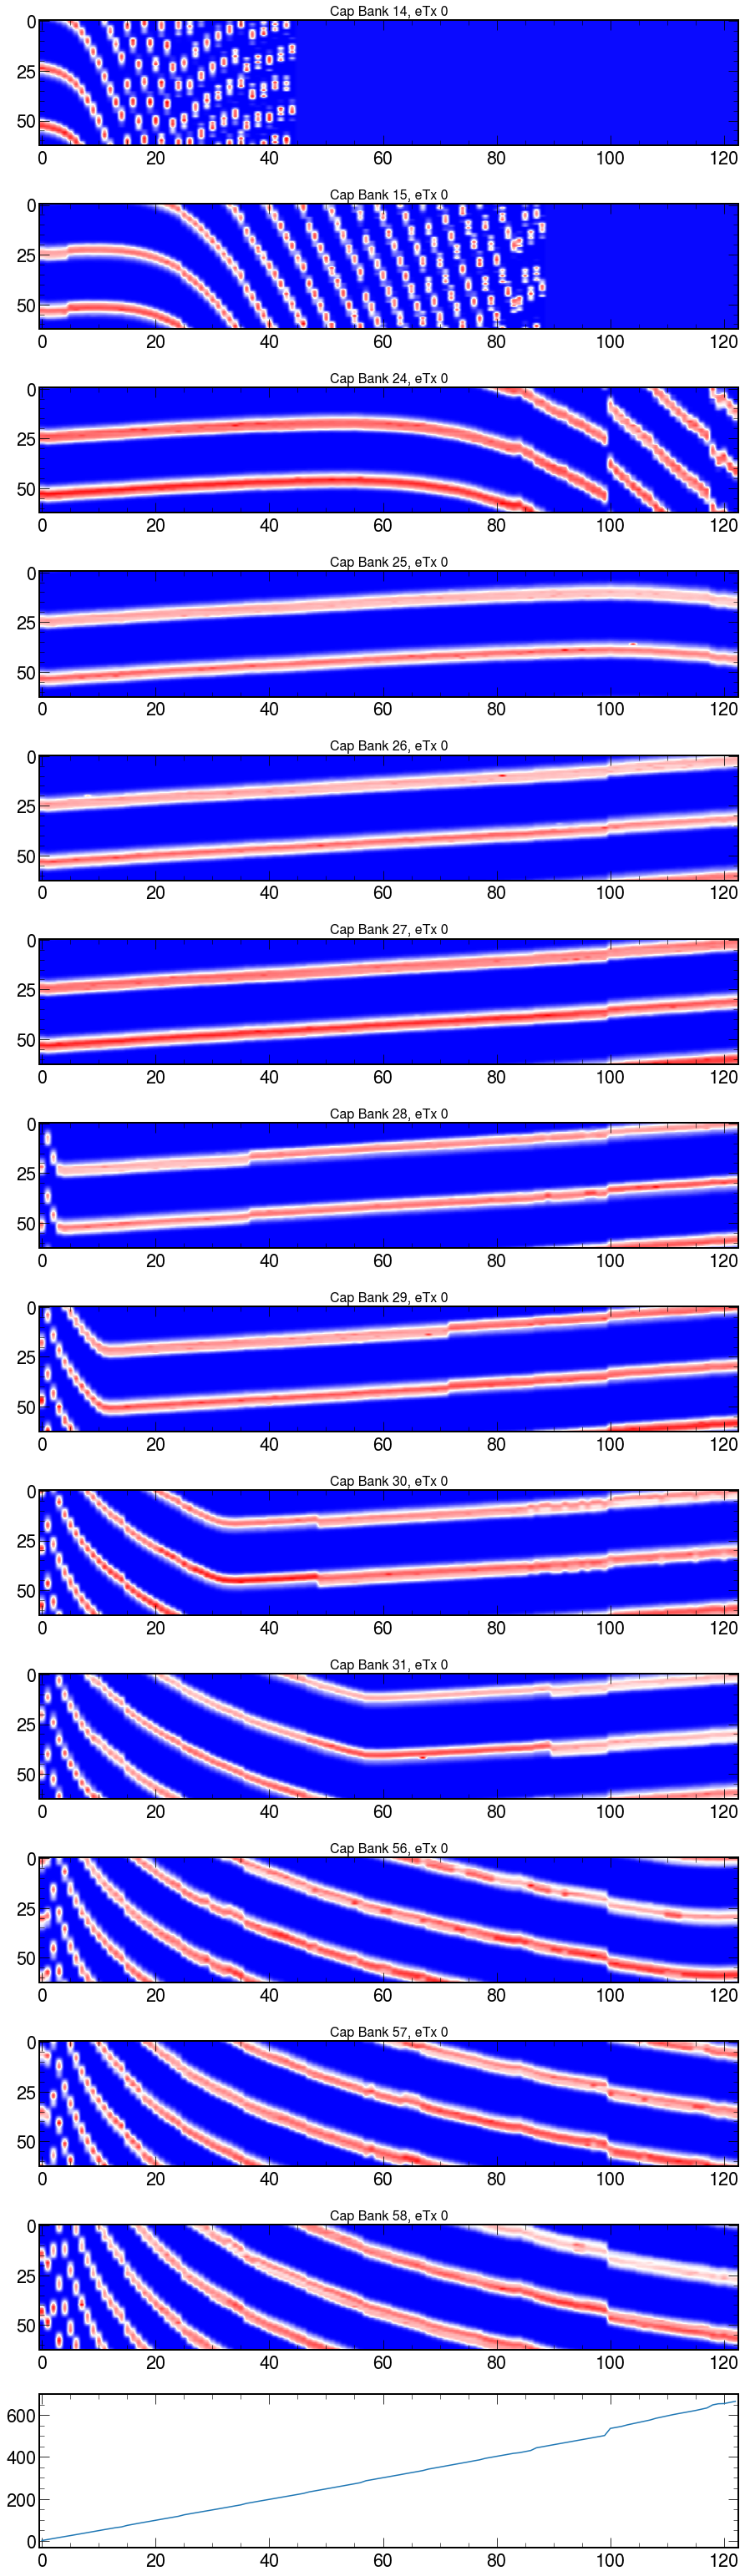

In [7]:
capBanks=[14,15,24,25,26,27,28,29,30,31,56,57,58]
d=df_9_120

fig, ax = plt.subplots(len(capBanks)+1,1,figsize=(15,len(capBanks)*4+4))
iETX=0
for i,n in enumerate(capBanks):
    x=np.array(list((d[f'phaseScan_CapSel{n}_eTx']).values))
    ax[i].imshow(x[:,:,iETX].T,cmap=mpl.colormaps['bwr'])
    ax[i].set_aspect(.35)
    ax[i].set_title(f'Cap Bank {n}, eTx {iETX}',fontsize=16)
#ax.set_xticklabels(df.index.values)

ax[-1].plot(np.arange(len(d)),d.TID)
# ax[1].set_aspect(.5)
ax[-1].set_xlim(-0.5,x.shape[0]-0.5);

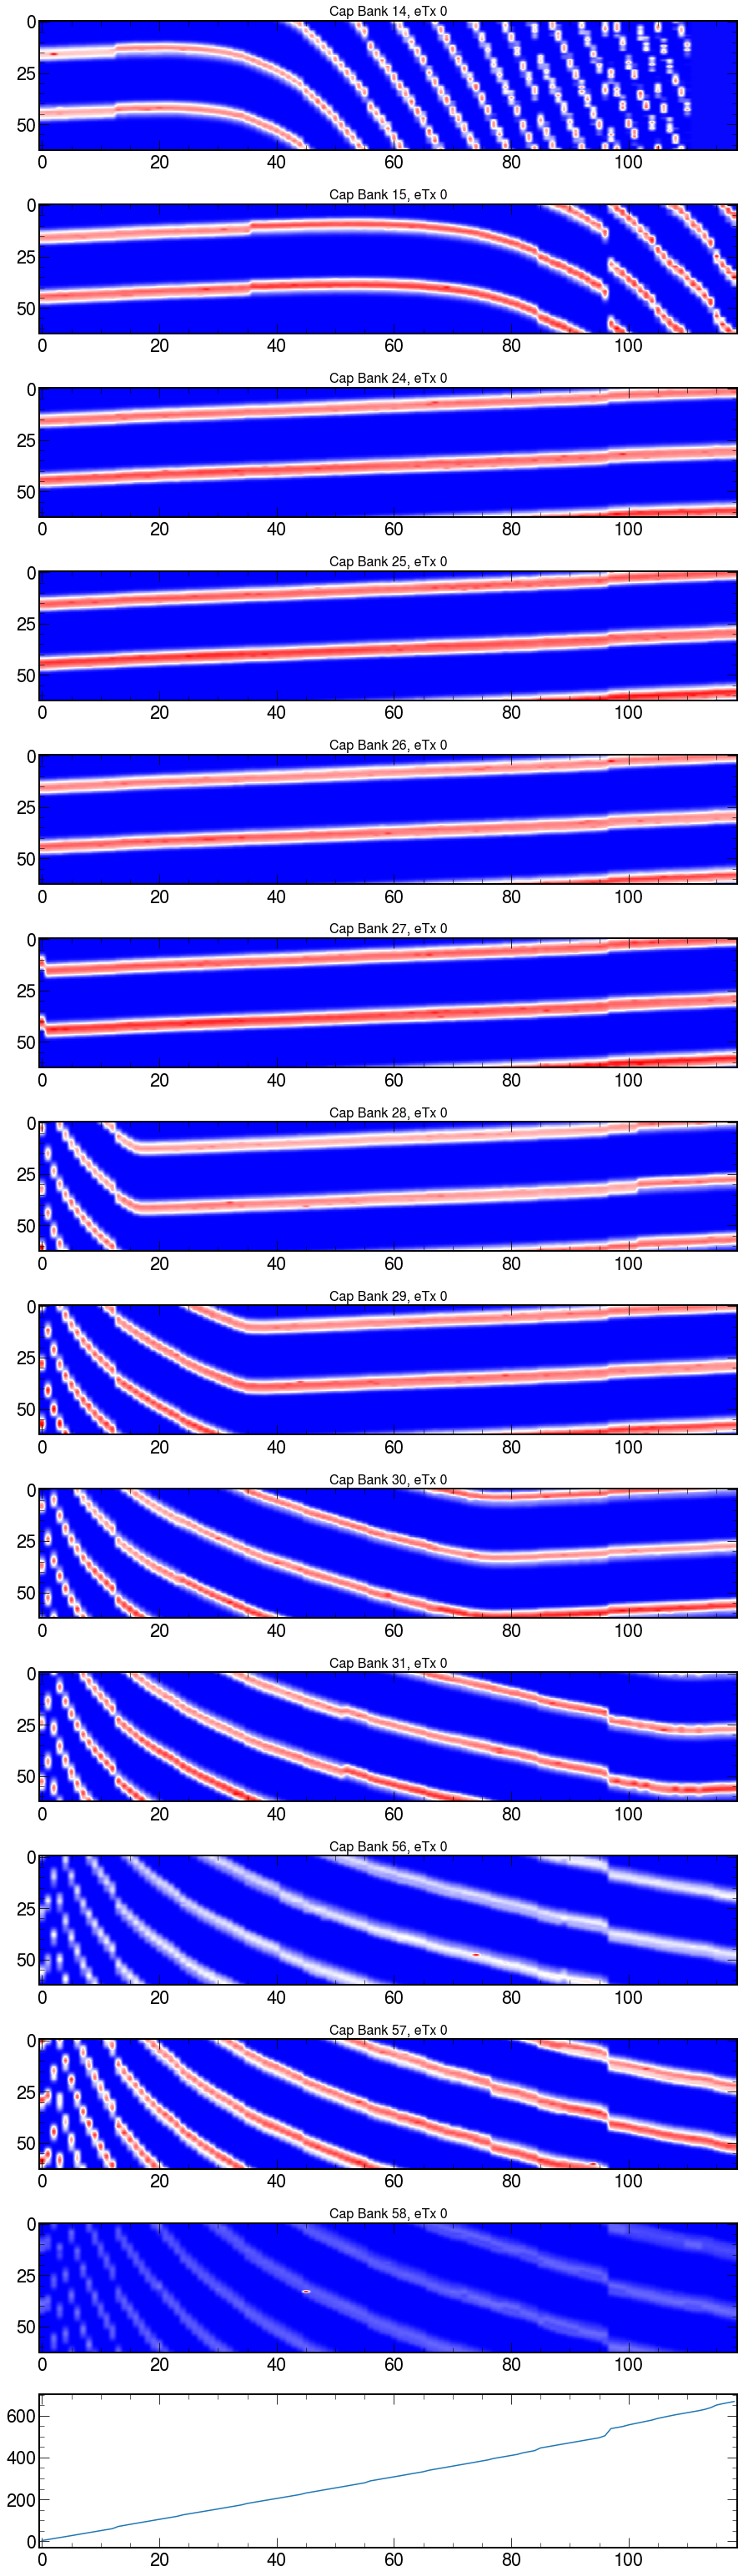

In [8]:
capBanks=[14,15,24,25,26,27,28,29,30,31,56,57,58]
d=df_9_132

fig, ax = plt.subplots(len(capBanks)+1,1,figsize=(15,len(capBanks)*4+4))
iETX=0
for i,n in enumerate(capBanks):
    x=np.array(list((d[f'phaseScan_CapSel{n}_eTx']).values))
    ax[i].imshow(x[:,:,iETX].T,cmap=mpl.colormaps['bwr'])
    ax[i].set_aspect(.35)
    ax[i].set_title(f'Cap Bank {n}, eTx {iETX}',fontsize=16)
#ax.set_xticklabels(df.index.values)

ax[-1].plot(np.arange(len(d)),d.TID)
# ax[1].set_aspect(.5)
ax[-1].set_xlim(-0.5,x.shape[0]-0.5);

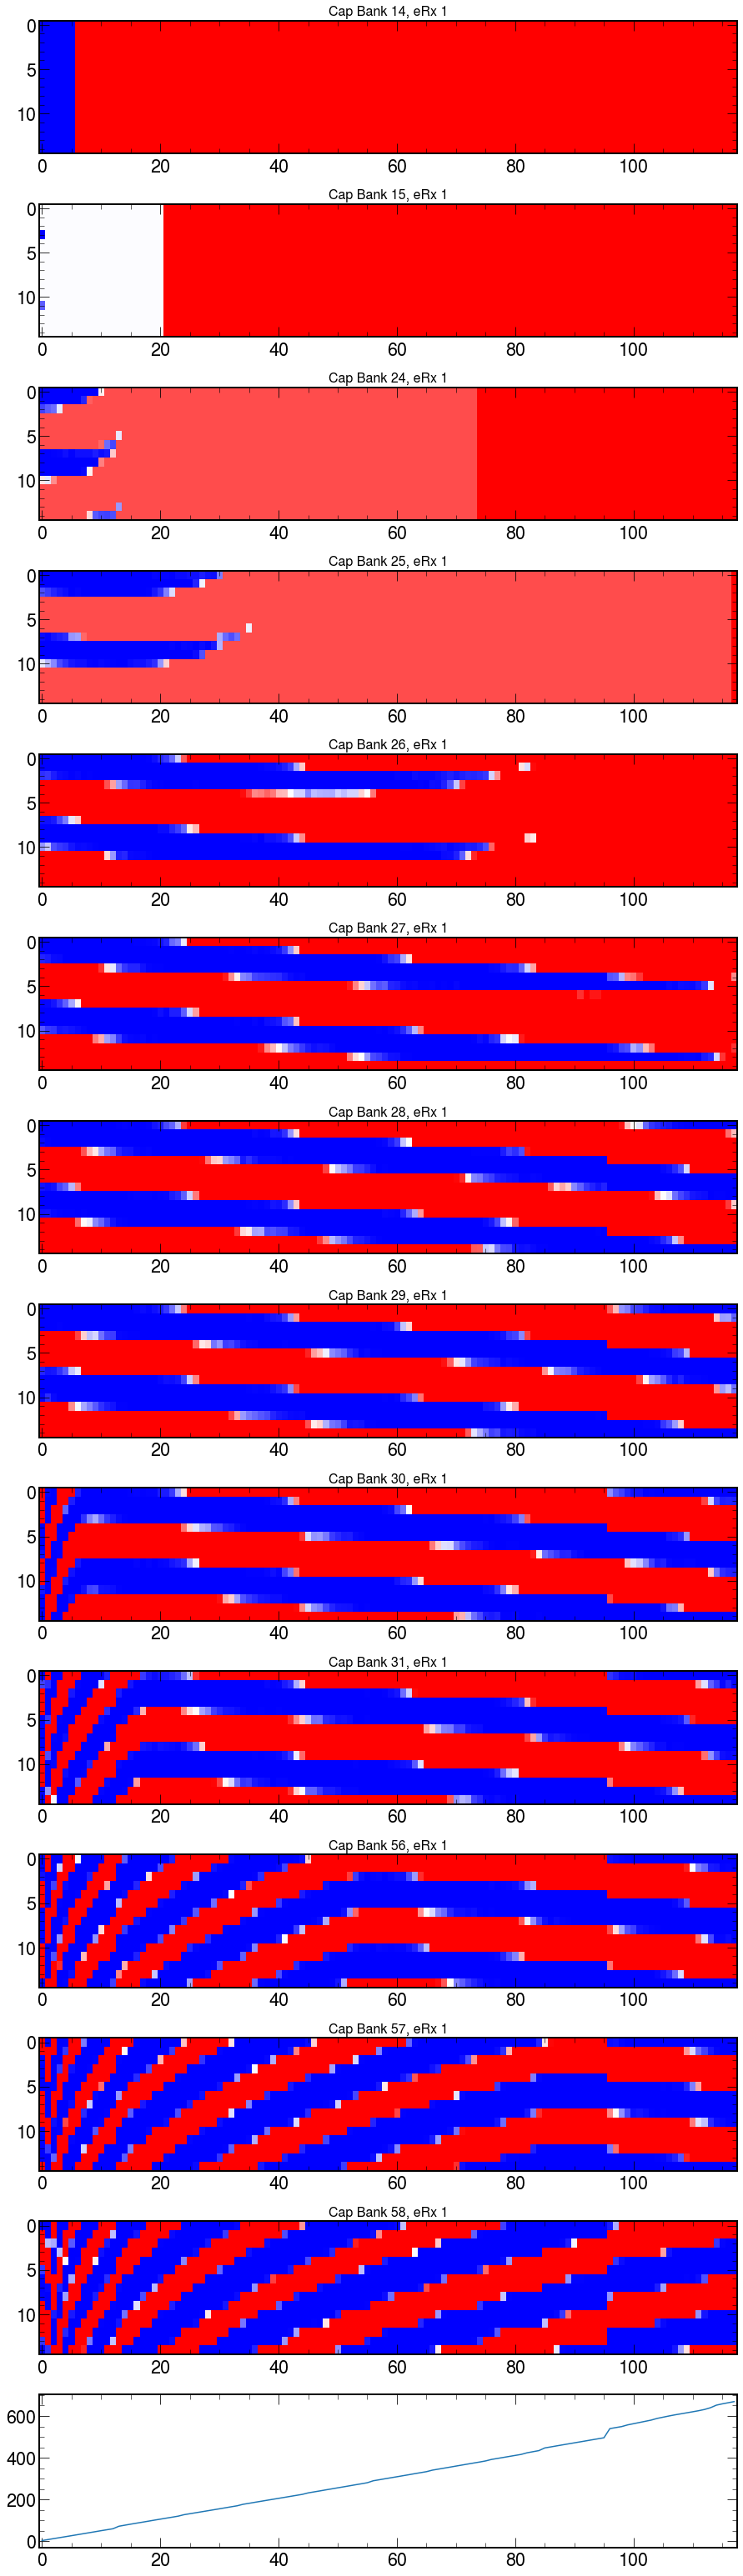

In [9]:
capBanks=[14,15,24,25,26,27,28,29,30,31,56,57,58]
d=df_9_108

fig, ax = plt.subplots(len(capBanks)+1,1,figsize=(15,len(capBanks)*4+4))
iERX=1
for i,n in enumerate(capBanks):
    x=np.array(list((d[f'phaseScan_CapSel{n}_eRx']).values))
    ax[i].imshow(x[:,:,iERX].T,cmap=mpl.colormaps['bwr'])
    ax[i].set_aspect(1.5)
    ax[i].set_title(f'Cap Bank {n}, eRx {iERX}',fontsize=16)
#ax.set_xticklabels(df.index.values)

ax[-1].plot(np.arange(len(d)),d.TID)
# ax[1].set_aspect(.5)
ax[-1].set_xlim(-0.5,x.shape[0]-0.5);

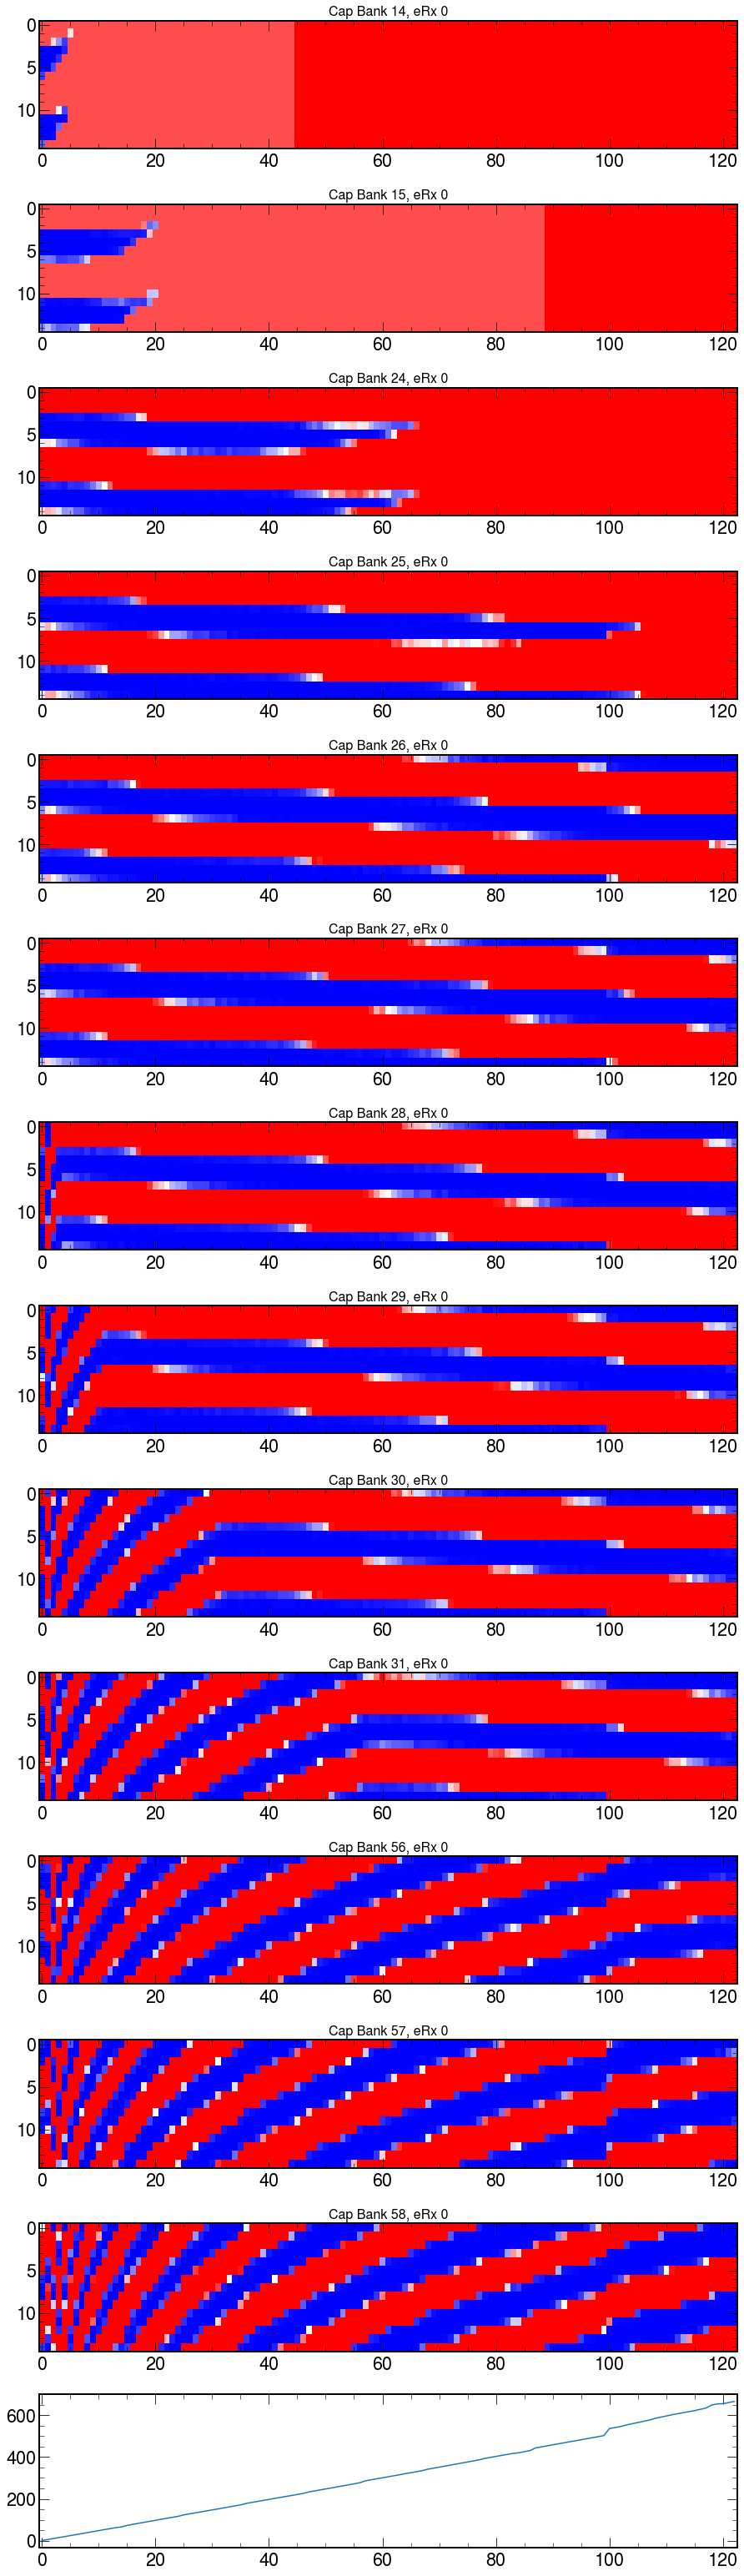

In [10]:
capBanks=[14,15,24,25,26,27,28,29,30,31,56,57,58]
d=df_9_120

fig, ax = plt.subplots(len(capBanks)+1,1,figsize=(15,len(capBanks)*4+4))
iERX=0
for i,n in enumerate(capBanks):
    x=np.array(list((d[f'phaseScan_CapSel{n}_eRx']).values))
    ax[i].imshow(x[:,:,iERX].T,cmap=mpl.colormaps['bwr'])
    ax[i].set_aspect(1.5)
    ax[i].set_title(f'Cap Bank {n}, eRx {iERX}',fontsize=16)
#ax.set_xticklabels(df.index.values)

ax[-1].plot(np.arange(len(d)),d.TID)
# ax[1].set_aspect(.5)
ax[-1].set_xlim(-0.5,x.shape[0]-0.5);